In [13]:
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import random
import math
from tqdm import tqdm

from numpy.ma.core import ceil
from scipy.spatial import distance  #distance calculation
from sklearn.preprocessing import MinMaxScaler  #normalisation
from sklearn.metrics import accuracy_score  #scoring
import matplotlib.pyplot as plt
from matplotlib import colors

In [14]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [15]:
# loading the train data
batch_size = 5

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Feature Extractor

In [17]:
feature_extractor = resnet34(weights="DEFAULT")
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
  param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

## Optimizer and Helper Functions

In [18]:

# Manhattan distance
def manhattan_distance(x, y):
    return distance.cityblock(x, y)


# Euclidean distance
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2, dim=-1))


# Calculate the learning rate and neighbourhood range based on the current training step.
def optimizer(step, max_steps, max_lr, max_m_distance):
    coefficient = 1.0 - (np.float64(step) / max_steps)
    # neighbourhood_range = ceil(coefficient * max_m_distance)
    neighbourhood_range = max_neighborhood_range
    learning_rate = coefficient * max_lr
    return learning_rate, neighbourhood_range


#Calculate the Gaussian distance based on the input value.
def distance_func(x):
    sig = 1 
    return np.exp(-np.power(x, 2.) / (2 * np.power(sig, 2.)))


## Hyperparameters

In [19]:
num_rows = 1
num_cols = 10
max_neighborhood_range = 1
max_learning_rate = 0.001
max_steps = 50000
is_2d_10_neuron = False


## Evaluation Measures

In [20]:
if not is_2d_10_neuron:
    num_neurons = num_rows * num_cols
else:
    num_neurons = num_rows * num_cols - 2


def create_label_map(map):
    """
      Create a label map and calculate label dispersion based on a given map.

      Parameters:
          label_map (array-like): The input map containing label information.

      Returns:
          tuple: A tuple containing the label map and the label dispersion map.

    """
    label_map = np.zeros(shape=(num_rows, num_cols), dtype=np.int64)
    label_dispersion = np.zeros(shape=(num_rows, num_cols), dtype=np.float64)
    for row in range(num_rows):
        for col in range(num_cols):
            label_list = map[row][col]
            if len(label_list) == 0:
                label = -3 # Invalid label when there are no labels in the list
                dispersion = 0.0
            else:
                label = max(label_list, key=label_list.count)  # Most frequent label in the list
                count_label = label_list.count(label)  # Number of occurrences of the most frequent label
                count_all_labels = len(label_list)  # Total number of labels in the list
                dispersion = count_label / count_all_labels  # Calculate the label dispersion

            label_map[row][col] = label
            label_dispersion[row][col] = dispersion
            
    return label_map, label_dispersion



def distance_som(som):
    """
    Calculate the distance map and U-matrix for a Self-Organizing Map (SOM).

    Parameters:
        som (array-like): Self-Organizing Map.

    Returns:
        tuple: A tuple containing the distance SOM map, average SOM distance, and U-matrix.

    """
    distance_som_map = np.empty(shape=(num_rows, num_cols), dtype=object)
    u_matrix = np.empty(shape=(num_rows, num_cols), dtype=np.float64)
    for row in range(num_rows):
        for col in range(num_cols):
            distance_som_map[row][col] = []

    total_dist = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if is_2d_10_neuron and (row == 3 and col == 0 or row == 3 and col == 2):
                pass
            else:
                u_value = 0
                for i in range(num_rows):
                    for j in range(num_cols):
                        if is_2d_10_neuron and (i == 3 and j == 0 or i == 3 and j == 2):
                            pass
                        else:
                            # Calculate the Euclidean distance between current neuron and other neurons
                            dist = euclidean_distance(som[row][col], som[i][j])
                            dist = dist.cpu().numpy()
                            total_dist += dist
                            u_value += dist
                            distance_som_map[row][col].append(dist)

                # Calculate the average distance (U-value) for the current neuron
                u_matrix[row][col] = u_value / num_neurons

    return distance_som_map, total_dist / num_neurons ** 2, u_matrix

## Find Best Matching Unit

In [21]:
# Best Matching Unit search
def bmu_search(data, som, num_rows, num_cols):
    """
    Find the Best Matching Unit (BMU) in the Self-Organizing Map (SOM) for a given input data.

    Parameters:
        data (array-like): Input data to find the BMU for.
        som (array-like): Self-Organizing Map.
        num_rows (int): Number of rows in the SOM.
        num_cols (int): Number of columns in the SOM.

    Returns:
        tuple: The coordinates of the BMU in the SOM grid and the distance between the BMU and the input data.

    """
    winner = [0, 0]
    shortest_distance = 10e6
    for row in range(num_rows):
        for col in range(num_cols):
            distance = euclidean_distance(som[row][col], data)
            if distance < shortest_distance:
                shortest_distance = distance
                winner = [row, col]
    return winner, shortest_distance

## Initializing Self Organising Map

In [22]:
num_features = 512  # numnber of dimensions in the input data

if is_2d_10_neuron:
    np.random.seed(3407)
    som = np.random.random_sample(size=(num_rows, num_cols, num_features))  # map construction
    som[3][0] = 10e9
    som[3][2] = 10e9
    som = torch.from_numpy(som).to(device)

else:
    np.random.seed(3407)
    som = np.random.random_sample(size=(num_rows, num_cols, num_features))  # map construction
    som = torch.from_numpy(som).to(device)


# Training
performs training and evaluation iterations for a Self-Organizing Map (SOM)

In [23]:
# Set the number of epochs and initialize the step counter
epochs = 1
step = 0

# Initialize arrays to store the final SOM labels, BMU labels, label dispersion, and U-matrix
final_som_label = np.zeros(shape=(num_rows, num_cols), dtype=np.int64)
final_bmu_labels = np.empty(shape=(num_rows, num_cols), dtype=object)
final_label_dispersion = np.zeros(shape=(num_rows, num_cols), dtype=np.float64)
final_u_matrix = np.zeros(shape=(num_rows, num_cols), dtype=np.float64)

for epoch in range(epochs):
    q_error = 0 # Initialize quantization error

    # Initialize empty arrays to store the BMU labels for each neuron
    bmu_labels = np.empty(shape=(num_rows, num_cols), dtype=object)
    for row in range(num_rows):
        for col in range(num_cols):
            bmu_labels[row][col] = []

    final_features = torch.zeros(0, dtype=torch.long, device=device)
    final_y = torch.zeros(0, dtype=torch.long, device=device)
    bmus = [] # Initialize list to store BMUs

    # Iterate over the training data
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", colour="blue"):
        x_train, y_train = x_train.to(device), y_train.to(device)
        features = feature_extractor(x_train) # Extract features from input data

        label_data = y_train.cpu().numpy()
        final_features = torch.cat([final_features] + [f.view(1, -1).detach().clone() for f in features])
        final_y = torch.cat([final_y, y_train.view(-1)])

        # start training iteration for each input feature
        for i in range(features.shape[0]):
            step += 1
            learning_rate, neighbourhood_range = optimizer(step, max_steps * epochs, max_learning_rate, max_neighborhood_range)

            # Find the winner neuron (BMU) and its distance from the input
            bmu, dis = bmu_search(features[i], som, num_rows, num_cols)
            dis = dis.cpu().numpy()
            #quantization error
            q_error += dis

            bmu_labels[bmu[0]][bmu[1]].append(label_data[i])  # Append the label of the current BMU to the corresponding neuron
            bmus.append(bmu)  # Add the current BMU to the list of BMUs

            # Update the weights of neighboring neurons based on their distance from the BMU
            for row in range(num_rows):
                for col in range(num_cols):
                    if is_2d_10_neuron and (row == 3 and col == 0 or row == 3 and col == 2):
                        pass
                    else:
                        dist = manhattan_distance([row, col], bmu)
                        if dist <= neighbourhood_range:
                            som[row][col] += distance_func(dist) * learning_rate * (
                                        features[i] - som[row][col])  #update neighbour's weight

    #evalation measures
    som_label, label_dispersion = create_label_map(bmu_labels)
    labels_from_bmu = np.zeros(shape=len(bmus), dtype=np.int64)
    for i, bmu in enumerate(bmus):
        labels_from_bmu[i] = som_label[bmu[0]][bmu[1]]

    quantization_error = q_error / len(bmus)
    acc = accuracy_score(final_y.cpu().numpy(), labels_from_bmu)
    f1 = f1_score(final_y.cpu().numpy(), labels_from_bmu, average='weighted')
    avg_dispersion = np.sum(label_dispersion)/num_rows * num_cols
    som_dist_map, avg_som_dist, u_matrix = distance_som(som)

    #save label maps to visualize data
    if epoch == epochs - 1:
        final_bmu_labels = bmu_labels
        final_som_label = som_label
        final_label_dispersion = label_dispersion
        final_u_matrix = u_matrix

    print("Accuracy: ", acc)
    print("F1 score:", f1)
    print("avg dispersion:", avg_dispersion)
    print("quantization error: ", quantization_error)
    print("avg neuron distances :", avg_som_dist)
    print("Learning Rate:", learning_rate)


Epoch 1: 100%|██████████| 10000/10000 [03:16<00:00, 50.79it/s]


Accuracy:  0.26084
F1 score: 0.18344421681491271
avg dispersion: 31.307037394176515
quantization error:  19.106428142351287
avg neuron distances : 8.248473031515498
Learning Rate: 0.0


## Test Data
using the trained som, search the winning node of corresponding to the test data 

In [24]:
sum_acc = 0
sum_f1 = 0
n = 0

for x_test, y_test in test_dataloader:
    x_test, y_test = x_test.to(device), y_test.to(device)
    features = feature_extractor(x_test)

    winner_labels = []

    for t in range(features.shape[0]):
        bmu = bmu_search(features[t], som, num_rows, num_cols)
        row = bmu[0][0]
        col = bmu[0][1]
        predicted = final_som_label[row][col]
        winner_labels.append(predicted)
    acc = accuracy_score(y_test.cpu().numpy(), winner_labels)
    f1 = f1_score(y_test.cpu().numpy(), winner_labels, average='weighted')
    sum_f1 += f1
    sum_acc += acc
    n += 1

print("Total Accuracy: ", sum_acc / n)
print("Average F1 score:", sum_f1 / n)
print("Average Dispersion :", avg_dispersion)

Total Accuracy:  0.29569999999999796
Average F1 score: 0.2835928571428554
Average Dispersion : 31.307037394176515


## Feature Map

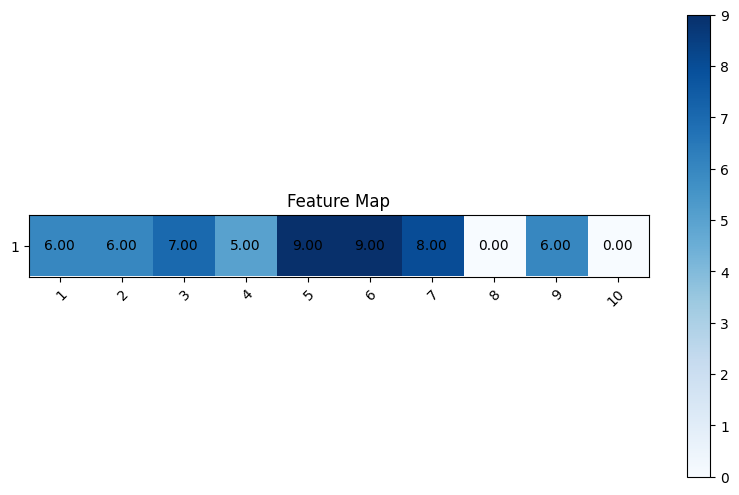

In [25]:
title = ('Feature Map')
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(final_som_label, cmap='Blues')
ax.set_xticks(np.arange(num_cols))
ax.set_yticks(np.arange(num_rows))
ax.set_xticklabels(np.arange(1, num_cols + 1))
ax.set_yticklabels(np.arange(1, num_rows + 1))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(num_rows):
    for j in range(num_cols):
        text = ax.text(j, i, '{:.2f}'.format(final_som_label[i][j]),
                       ha="center", va="center", color="black")

plt.colorbar()
plt.title(title)
plt.show()

## U-Matrix

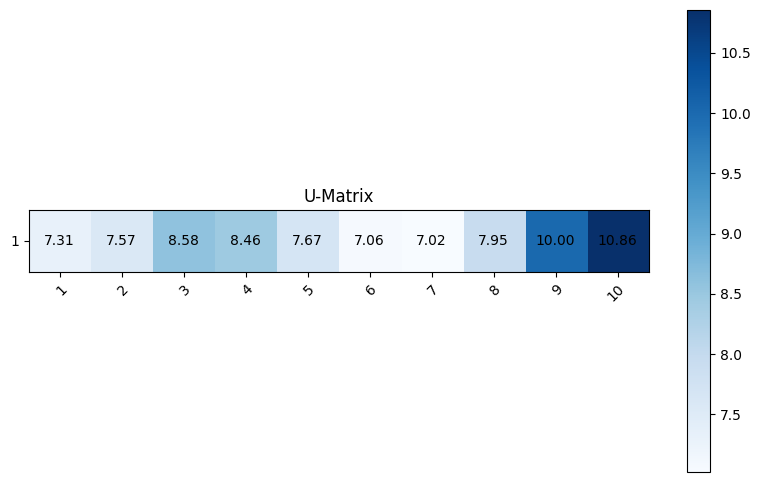

In [26]:
title = 'U-Matrix'
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(final_u_matrix, cmap='Blues')
ax.set_xticks(np.arange(num_cols))
ax.set_yticks(np.arange(num_rows))
ax.set_xticklabels(np.arange(1, num_cols + 1))
ax.set_yticklabels(np.arange(1, num_rows + 1))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(num_rows):
    for j in range(num_cols):
        text = ax.text(j, i, '{:.2f}'.format(final_u_matrix[i][j]), ha="center", va="center", color="black")

plt.colorbar()
plt.title(title)
plt.show()


## dispersion map

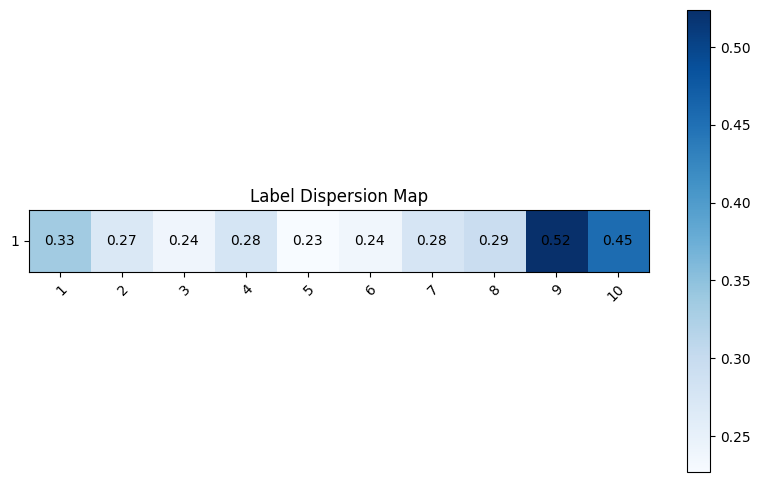

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(final_label_dispersion, cmap='Blues')
ax.set_xticks(np.arange(num_cols))
ax.set_yticks(np.arange(num_rows))
ax.set_xticklabels(np.arange(1, num_cols + 1))
ax.set_yticklabels(np.arange(1, num_rows + 1))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(num_rows):
    for j in range(num_cols):
        text = ax.text(j, i, '{:.2f}'.format(final_label_dispersion[i][j]),
                       ha="center", va="center", color="black")

plt.title('Label Dispersion Map')
plt.colorbar(im)
plt.show()

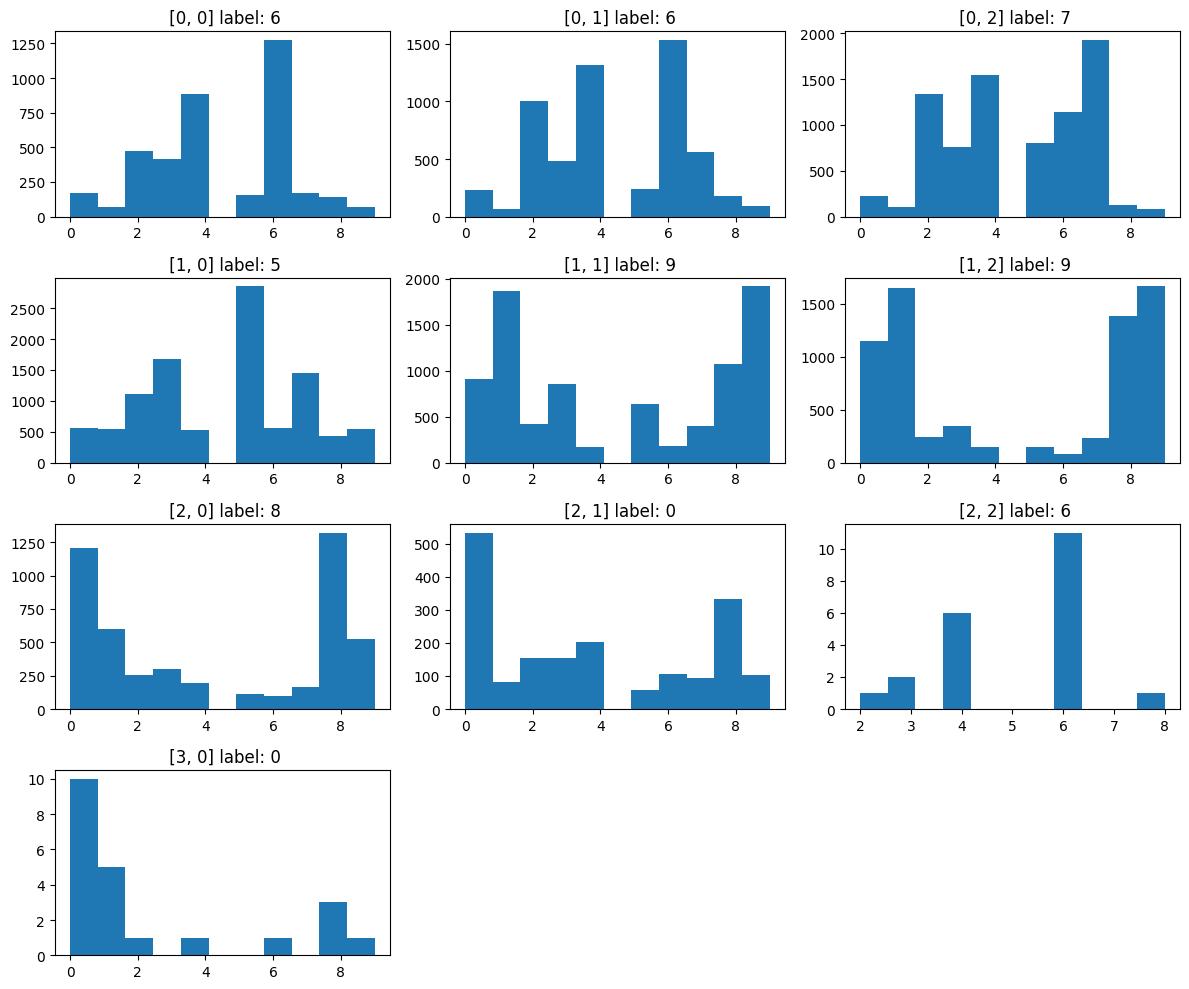

In [28]:
figure_size = (12, 10)
num_figures = num_rows * num_cols
num_cols_per_row = int(num_figures ** 0.5)  # Number of columns per row
num_rows_per_col = (num_figures + num_cols_per_row - 1) // num_cols_per_row  # Number of rows per column

fig, axes = plt.subplots(num_rows_per_col, num_cols_per_row, figsize=figure_size)
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

for k in range(num_figures):
    i = k // num_cols_per_row
    j = k % num_cols_per_row

    x = k // num_cols
    y = k % num_cols

    z = final_bmu_labels[x][y]  # Convert y to a list or iterable
    ax = axes[i, j]  # Get the corresponding axis
    ax.hist(z, bins=11)
    ax.set_title(f' [{i}, {j}] label: {final_som_label[x][y]}')

# Hide empty subplots if num_figures is not a perfect square
for k in range(num_figures, num_rows_per_col * num_cols_per_row):
    axes[k // num_cols_per_row, k % num_cols_per_row].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [29]:
# figure_size = (10, 8)
# for i in range(num_rows):
#     for j in range(num_cols):
#         y = final_bmu_labels[i][j]  # Convert y to a list or iterable
#         print(final_som_label[i][j])
#         #         colors = ['green' if final_som_label[i][j] in y else 'blue' for k in y]
#         plt.figure(figsize=figure_size)
#         plt.hist(y, bins=11)
#         plt.title(f'labels for neuron [{i}, {j}] selcted label: {final_som_label[i][j]}')
#         plt.show()


In [30]:
# batch_size= 1
# train_data = datasets.CIFAR10('data', train=True,
#                               download=True, transform=transform)
# som_init_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )
# num_features = 512

# def initial_som():

#   unique_labels = list(set(train_data.targets))
#   random.shuffle(unique_labels)
#   selected_samples = []
#   selected_labels = []

#   # Iterate over the train_dataloader until we have selected enough samples
#   for x_train, y_train in som_init_dataloader:
#       x_train, y_train = x_train.to(device), y_train.to(device)
#       feature = feature_extractor(x_train).cpu().numpy()


#       # Check if the label is one of the unique labels and has not been selected already
#       if y_train[0] not in [label for label in selected_labels]:
#         selected_labels.append(y_train[0])
#         selected_samples.append(feature[0])

#       # Break the outer loop if we have collected enough samples
#       if len(selected_samples) == num_rows * num_cols:
#           break
#   print(selected_labels)


#   # Initialize SOM with random values
#   np.random.seed(40)
#   som = np.random.random_sample(size=(num_rows, num_cols, num_features)) # map construction

#   i =0
#   for row in range(num_rows):
#     for col in range(num_cols):
#       if not is_2d_10_neuron:
#         som[row][col] = selected_samples[i]
#         i+=1
#       else:
#         if (row == 3 and col == 0) or (row == 3 and col == 2):
#           som[row][col] = 10e9
#         else:
#           som[row][col] = selected_samples[i]
#           i+=1
#         som[3][0] = 10e9
#         som[3][2] = 10e9
#   return som


# som = initial_som()
# som = torch.from_numpy(som).to(device)